In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import ipdb

# Pipelines (a.k.a parts of the Neural Network)
from Pipelines.kitti_loader import KITTIDataset
from Pipelines.pillarizer import PillarFeatureNet, Pillarization, PseudoImageDataset
from Pipelines.backbone import BackBone
from Pipelines.detection_head import DetectionHead


print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [2]:
#train_pointclouds_full_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne'

train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'
test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)

# TODO: Add Loader for test set (No labels)

Visualize a pointcloud with its annotations

In [3]:
import open3d as o3d

def draw_box_o3d(corners, color=[1, 0, 0]):
    # Define the edges of the bounding box
    lines = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # lower edges
        [4, 5], [5, 6], [6, 7], [7, 4],  # upper edges
        [0, 4], [1, 5], [2, 6], [3, 7]   # vertical edges
    ]
    # Create lines set object in open3d
    lines_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(corners),
        lines=o3d.utility.Vector2iVector(lines),
    )
    # Set the color of the bounding box
    lines_set.colors = o3d.utility.Vector3dVector([color for i in range(len(lines))])
    return lines_set

def plot_point_cloud_with_bboxes_o3d(point_cloud, annotations):
    # Create open3d point cloud object
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])  # Assuming the point cloud is (N, 3)

    # Create a list to hold all the geometries to be visualized
    geometries = [pcd]

    # For each car annotation, create and add a bounding box
    for annotation in annotations.get('Car', []):
        h, w, l = annotation['dimensions']
        y, z, x = annotation['location']  # Adjust based on the KITTI dataset's convention

        # Compute x, y, z in velodyne frame
        y = -y
        z = -z

        ry = annotation['rotation_y']

        # Create a bounding box in the vehicle's reference frame
        corners = np.array([
            [l / 2, w / 2, 0],
            [-l / 2, w / 2, 0],
            [-l / 2, -w / 2, 0],
            [l / 2, -w / 2, 0],
            [l / 2, w / 2, h],
            [-l / 2, w / 2, h],
            [-l / 2, -w / 2, h],
            [l / 2, -w / 2, h],
        ])

        # Rotate the bounding box
        rotation_matrix = np.array([
            [np.cos(ry), -np.sin(ry), 0],
            [np.sin(ry), np.cos(ry), 0],
            [0, 0, 1]
        ])
        corners_rotated = np.dot(corners, rotation_matrix.T)

        # Translate the bounding box
        corners_rotated += np.array([x, y, z])

        # Create and add the bounding box to the geometries list
        bbox = draw_box_o3d(corners_rotated)
        geometries.append(bbox)

    # Visualize the point cloud and bounding boxes
    o3d.visualization.draw_geometries(geometries)

    return geometries

# Example usage:
point_cloud, labels = train_set[5001]  # Replace 0 with the index of the point cloud you want to visualize
geometries = plot_point_cloud_with_bboxes_o3d(point_cloud.numpy(), labels)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/000333.bin


/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


How are we getting labels?

In [4]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')
    
# Test Pillarization:
'''pillarizer = Pillarization(aug_dim=9, x_min=0.0, x_max=70.4, y_min=-40.0, y_max=40.0, 
                                        z_min=-3, z_max=1, pillar_size=(0.16, 0.16), 
                                        max_points_per_pillar=100, max_pillars=12000)

pillars = pillarizer.make_pillars(train_set[0][0])'''



'pillarizer = Pillarization(aug_dim=9, x_min=0.0, x_max=70.4, y_min=-40.0, y_max=40.0, \n                                        z_min=-3, z_max=1, pillar_size=(0.16, 0.16), \n                                        max_points_per_pillar=100, max_pillars=12000)\n\npillars = pillarizer.make_pillars(train_set[0][0])'

In [5]:
# Create a collate function to handle variable-sized labels:
def collate_batch(batch):
    point_clouds, annotations = zip(*batch)
    
    # Convert lists of point clouds and annotations into tensors
    point_clouds = torch.stack(point_clouds, dim=0)
    
    # Padding for variable-sized labels:
    max_annotations = max(len(a['Car']) for a in annotations)
    padded_annotations = []
    for a in annotations:
        # Pad each annotation to have max_annotations entries
        car_annotations = a['Car'] + [{}] * (max_annotations - len(a['Car']))
        padded_annotations.append({'Car': car_annotations})
    
    return point_clouds, padded_annotations

        
# Create the dataset and DataLoader
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir, device=device, kitti_dataset=train_set, aug_dim=AUG_DIM, max_points_in_pillar=MAX_POINTS_PER_PILLAR,
                             max_pillars=MAX_FILLED_PILLARS, x_min=X_MIN, y_min=Y_MIN, z_min=Z_MIN, x_max = X_MAX, y_max=Y_MAX,
                             z_max = Z_MAX, pillar_size=PILLAR_SIZE)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)


# Iterate through batches:  
for batch_idx, (pseudo_image, label) in enumerate(train_loader):
    break # TODO: Erase this and load the entire dataset

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/005198.bin
Loading point cloud number 3232
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/004421.bin
Loading point cloud number 7473
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/000367.bin
Loading point cloud number 5473
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/004615.bin
Loading point cloud number 4281


In [6]:
pseudo_image.size()

torch.Size([4, 64, 500, 440])

In [7]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

In [8]:

backbone = BackBone(in_channels=64, out_channels=64, device=device)
backbone_features = backbone(pseudo_image)

In [9]:
backbone_features.size()




torch.Size([4, 384, 500, 440])

Now, implement the Detection Head:

In [10]:
#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(device=device, in_channels=backbone_features.size()[1], grid_size_x=backbone_features.size()[2], 
                        grid_size_y=backbone_features.size()[3], num_anchors=4, num_classes=2) #TODO: Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

In [12]:
size.size()

torch.Size([4, 4, 3, 500, 440])

Create anchors for Single-Shot Detector:

/home/adlink/anaconda3/envs/test/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


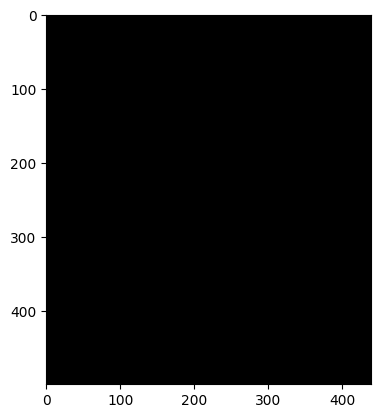

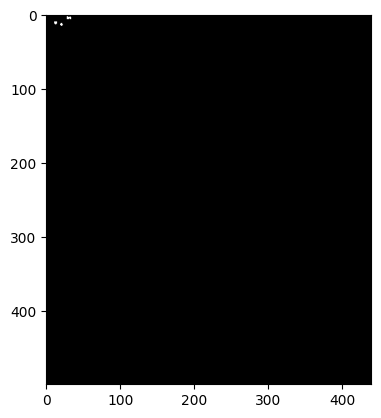

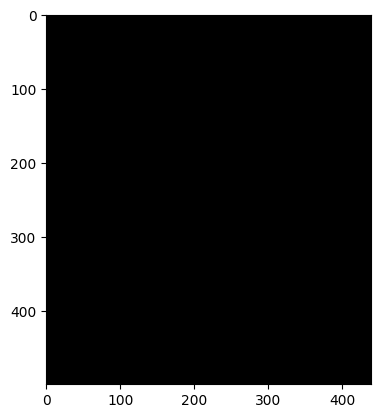

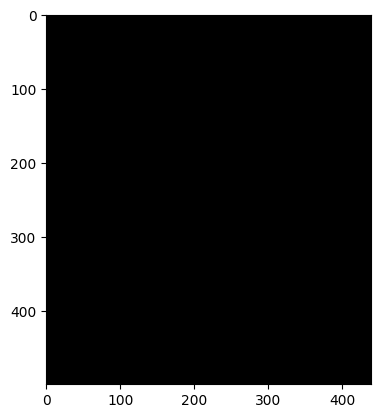

In [37]:
def transform_to_canvas(x_center, y_center, x_min, y_min, radius, pillar_size):
    x_center_img = (x_center - x_min) // pillar_size[0]
    y_center_img = (y_center - y_min) // pillar_size[1]
    radius_img = radius / pillar_size[0] # TODO: This assumes that pillar_size is the same in x and y
    return x_center_img, y_center_img, radius_img


# Anchors as tensor: (length, width, height, z_center, orientation)
anchor_dims = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # TODO: Declare at the top
                       [3.9, 1.6, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.8, 0.6, 1.73, -0.6, 1.5708]]
                       )


# TODO: For each 3D bounding box provided in the label files, a search radius is defined 
# around the original bounding box based on object dimensions (represented as a red circle in a grid).
for gt_label in label:
    if gt_label['Car'] == [{}, {}, {}, {}, {}, {}, {}]:
        continue

    # Create target radius:
    target_radii = []

    # Number of objects: 
    n_objects = len(gt_label['Car'])

    # Create empty tensor that holds target circles:
    target_circles = torch.zeros(n_objects, 3) # Tensor will hold (x_center, y_center and radius of the target circle for applying the anchors)

    # Empty canvas for visualization if needed:
    canvas = torch.zeros(loc.size()[-2], loc.size()[-1])

    margin = 2.0 # Adds to the box to get the target radius for SSD

    # Iterate over targets to set target_radii and apply anchors
    for i in range(n_objects):
        if gt_label['Car'][i] == {}: # If true, done with target generation
            break
        x_center = gt_label['Car'][i]['location'][2]
        y_center = gt_label['Car'][i]['location'][0]
        height = gt_label['Car'][i]['dimensions'][0]
        width = gt_label['Car'][i]['dimensions'][1]

        # TODO: Transform targets to pseudo_image_frame:
        target_radius = max(height, width) + margin
        target_circles[i,0:3] = torch.tensor([x_center, y_center, target_radius])

        x_center_tr, y_center_tr, target_radius_tr =  transform_to_canvas(x_center=x_center, 
            y_center=y_center, x_min=X_MIN, y_min=Y_MIN, radius=target_radius, pillar_size=PILLAR_SIZE)
        
        # TODO: Mask canvas to display circles if visualization is needed:
        y, x = torch.meshgrid(torch.arange(canvas.size(0)), torch.arange(canvas.size(1)))
        mask = (x - x_center_tr) ** 2 + (y - y_center_tr) ** 2 <= target_radius_tr ** 2
        canvas[mask] = 1  # Set the masked locations to 1

    canvas_numpy = canvas.numpy()
    plt.imshow(canvas_numpy, cmap='gray')
    plt.show()


    # TODO: Apply each anchor and get the anchor with the highest IoU:

        

    

In [35]:
loc.size()[-1]

440

In [26]:
anchor_dims

tensor([[ 3.9000,  1.6000,  1.5600, -1.0000,  0.0000],
        [ 3.9000,  1.6000,  1.5600, -1.0000,  1.5708],
        [ 0.8000,  0.6000,  1.7300, -0.6000,  0.0000],
        [ 0.8000,  0.6000,  1.7300, -0.6000,  1.5708]])

In [27]:



# TODO: createPillarsTarget function: This function is tasked with generating regression targets, which are 
# essential for subsequent loss value calculations. It follows these steps:


# TODO: For each 3D bounding box provided in the label files, a search radius is defined 
# around the original bounding box based on object dimensions (represented as a red circle in a grid).
for gt_label in label:
    if gt_label['Car'] == [{}, {}, {}, {}, {}, {}, {}]:
        continue

    # Create target radius:
    target_radii = []

    # Number of objects: 
    n_objects = len(gt_label['Car'])

    # Create empty tensor that holds target circles:
    target_circles = torch.zeros(n_objects, 3) # Tensor will hold (x_center, y_center and radius of the target circle for applying the anchors)

    # Iterate over targets to set target_radii and apply anchors
    for i in range(n_objects):
        if gt_label['Car'][i] == {}:
            n_objects = i
            break

        #target_radii.append(TargetRadius(x_center=gt_label['Car'][i]['location'][2], 
        #                        y_center=gt_label['Car'][i]['location'][0], radius=6.0))
        x_center = gt_label['Car'][i]['location'][2]
        y_center = gt_label['Car'][i]['location'][0]
        height = gt_label['Car'][i]['dimensions'][0]
        width = gt_label['Car'][i]['dimensions'][1]

        target_radius = max(height, width)
        target_circles[i,0:3] = torch.tensor([x_center, y_center, target_radius])


RuntimeError: The expanded size of the tensor (2) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [2].  Tensor sizes: [3]

In [23]:
label

[{'Car': [{}, {}, {}, {}, {}, {}, {}]},
 {'Car': [{'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.57,
    'bbox': [571.3, 178.99, 603.66, 208.48],
    'dimensions': [1.6, 1.76, 3.84],
    'location': [-1.18, 1.26, 41.34],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.93,
    'occluded': 0,
    'alpha': -0.81,
    'bbox': [0.0, 209.69, 212.48, 375.0],
    'dimensions': [1.38, 1.71, 4.49],
    'location': [-4.78, 1.64, 4.77],
    'rotation_y': -1.56,
    'score': None},
   {'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.09,
    'bbox': [85.19, 186.17, 282.49, 280.48],
    'dimensions': [1.54, 1.65, 3.82],
    'location': [-8.03, 1.58, 14.0],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha': -1.18,
    'bbox': [246.43, 185.37, 368.07, 246.86],
    'dimensions': [1.49, 1.67, 4.05],
    'location': [-8.22, 1.52, 19.98],
    'rotation_y': -1.57,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha

Now, create the loss function:

In [17]:

class PointPillarLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(PointPillarLoss, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        # Unpack predictions and targets
        pred_boxes, pred_scores = predictions
        gt_boxes, gt_scores = targets
        
        # Calculate the residuals for the boxes
        da = torch.sqrt((pred_boxes[:, 3] - pred_boxes[:, 0])**2 + (pred_boxes[:, 4] - pred_boxes[:, 1])**2)
        dx = (gt_boxes[:, 0] - pred_boxes[:, 0]) / da
        dy = (gt_boxes[:, 1] - pred_boxes[:, 1]) / da
        dz = (gt_boxes[:, 2] - pred_boxes[:, 2]) / pred_boxes[:, 5]
        dw = torch.log(gt_boxes[:, 3] / pred_boxes[:, 3])
        dl = torch.log(gt_boxes[:, 4] / pred_boxes[:, 4])
        dh = torch.log(gt_boxes[:, 5] / pred_boxes[:, 5])
        dtheta = torch.sin(gt_boxes[:, 6] - pred_boxes[:, 6])
        
        # Stack the residuals
        residuals = torch.stack((dx, dy, dz, dw, dl, dh, dtheta), dim=1)
        
        # Calculate the SmoothL1 loss for localization
        loc_loss = self.smooth_l1_loss(pred_boxes, residuals)
        
        # Calculate the Focal loss for classification
        p = torch.sigmoid(pred_scores)
        pt = p * gt_scores + (1 - p) * (1 - gt_scores)  # p_t
        alpha_t = self.alpha * gt_scores + (1 - self.alpha) * (1 - gt_scores)
        cls_loss = -alpha_t * (1 - pt) ** self.gamma * (gt_scores * torch.log(p) + (1 - gt_scores) * torch.log(1 - p))
        
        # Sum up the localization and classification losses
        total_loss = loc_loss + cls_loss.sum()
        
        return total_loss

# Example usage:
model = ...  # Your model here
criterion = PointPillarLoss()

# Predictions from the model
pred_boxes = ...  # Your predicted boxes here (Nx7)
pred_scores = ...  # Your predicted scores here (Nx1)

# Targets
gt_boxes = ...  # Your ground truth boxes here (Nx7)
gt_scores = ...  # Your ground truth scores here (Nx1)

# Compute the loss
loss = criterion((pred_boxes, pred_scores), (gt_boxes, gt_scores))



[{'Car': [{}, {}, {}, {}, {}, {}, {}]},
 {'Car': [{'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.57,
    'bbox': [571.3, 178.99, 603.66, 208.48],
    'dimensions': [1.6, 1.76, 3.84],
    'location': [-1.18, 1.26, 41.34],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.93,
    'occluded': 0,
    'alpha': -0.81,
    'bbox': [0.0, 209.69, 212.48, 375.0],
    'dimensions': [1.38, 1.71, 4.49],
    'location': [-4.78, 1.64, 4.77],
    'rotation_y': -1.56,
    'score': None},
   {'truncated': 0.0,
    'occluded': 0,
    'alpha': -1.09,
    'bbox': [85.19, 186.17, 282.49, 280.48],
    'dimensions': [1.54, 1.65, 3.82],
    'location': [-8.03, 1.58, 14.0],
    'rotation_y': -1.6,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha': -1.18,
    'bbox': [246.43, 185.37, 368.07, 246.86],
    'dimensions': [1.49, 1.67, 4.05],
    'location': [-8.22, 1.52, 19.98],
    'rotation_y': -1.57,
    'score': None},
   {'truncated': 0.0,
    'occluded': 1,
    'alpha